### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.
C:\Users\a2541\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2541\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2541\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2541\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [9]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')


Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0061 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00235, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 457us/step - loss: 0.0016 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00235 to 0.00194, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 458us/step - loss: 0.0013 - val_loss: 0.0018

Epoch 00003: val_loss improved from 0.00194 to 0.00183, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 454us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00183
Epoch 5/150
1712/1712 [==============================] - 1s 457us/step - loss: 0.0010 - val_loss: 0.0017

Epoch 00005: val_loss improved from 0.00183 to 0.00174, saving model to best_weights.h5
Epoch 6/150
1712/1712 [==

1712/1712 [==============================] - 1s 460us/step - loss: 1.2607e-04 - val_loss: 7.7292e-04

Epoch 00093: val_loss did not improve from 0.00069
Epoch 94/150
1712/1712 [==============================] - 1s 462us/step - loss: 1.1483e-04 - val_loss: 7.6063e-04

Epoch 00094: val_loss did not improve from 0.00069
Epoch 95/150
1712/1712 [==============================] - 1s 456us/step - loss: 1.1655e-04 - val_loss: 7.2043e-04

Epoch 00095: val_loss did not improve from 0.00069
Epoch 96/150
1712/1712 [==============================] - 1s 457us/step - loss: 1.1506e-04 - val_loss: 7.1404e-04

Epoch 00096: val_loss did not improve from 0.00069
Epoch 97/150
1712/1712 [==============================] - 1s 458us/step - loss: 1.2096e-04 - val_loss: 7.0573e-04

Epoch 00097: val_loss did not improve from 0.00069
Epoch 98/150
1712/1712 [==============================] - 1s 465us/step - loss: 1.1592e-04 - val_loss: 7.2796e-04

Epoch 00098: val_loss did not improve from 0.00069
Epoch 99/150
1712

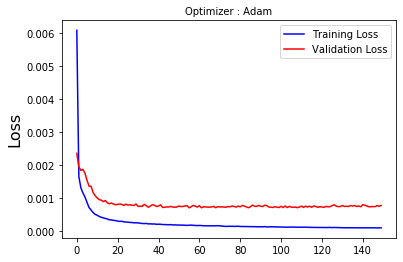

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [13]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

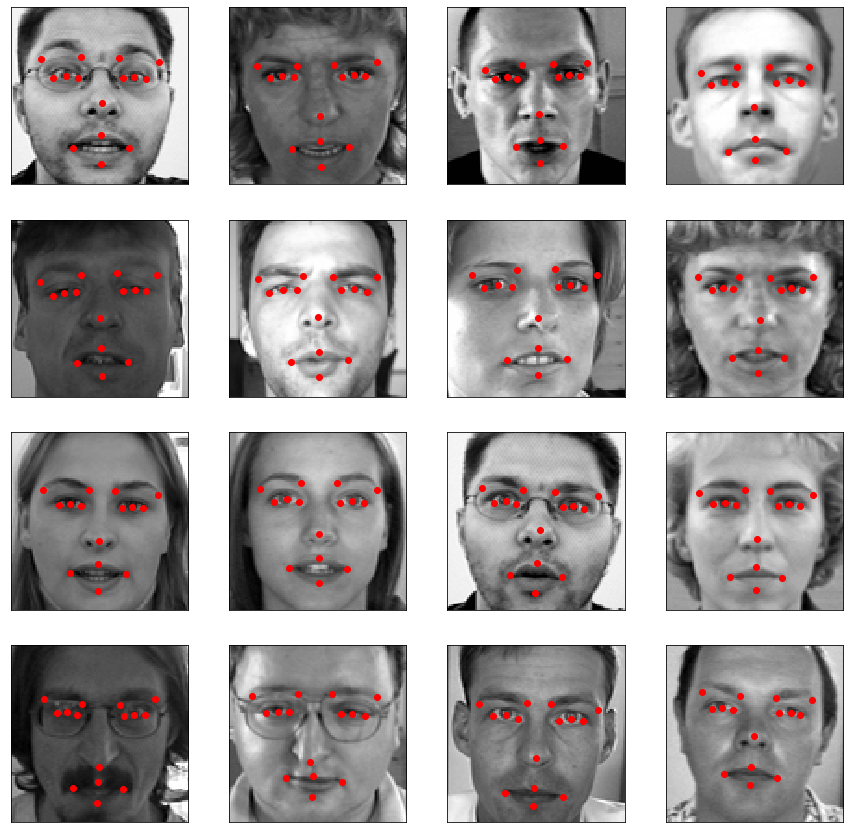

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [15]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
def augment_data(img, points):
    rows, cols = img.shape
    # np.copy(img)複製圖片
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    # np.copy(points):複製關鍵點
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

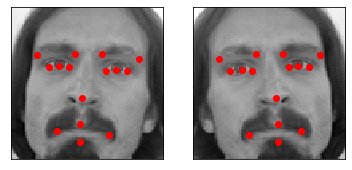

In [17]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

# 製作空白的figure來製作圖中圖
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[]) #xticks=[]:x軸刻度、yticks=[]:y軸刻度
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[]) #xticks=[]:x軸刻度、yticks=[]:y軸刻度
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [18]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [19]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True) #按固定間隔，存儲模型，預設是每個epoch存儲一次模型
# training the model
# 進行訓練, 訓練過程會存在 hist_model_aug 變數中
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), # 輸入數據 
                                        aug_points_train,  # 標籤
                                        validation_split=0.2, # 用來指定訓練集的一定比例數據作為驗證集
                                        batch_size=64, # 指定進行梯度下降時每個batch包含的樣本數。
                                        callbacks=[checkpoint_aug, hist],
                                        shuffle=True, #表示是否在訓練過程中每個epoch前隨機打亂輸入樣本的順序
                                        epochs=150, #訓練終止時的epoch值，訓練將在達到該epoch值時停止，
                                        verbose=1) #日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 2s 562us/step - loss: 0.0041 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00189, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 2s 461us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00189 to 0.00187, saving model to best_weights_augment.h5
Epoch 3/150
3424/3424 [==============================] - 2s 464us/step - loss: 0.0010 - val_loss: 0.0017

Epoch 00003: val_loss improved from 0.00187 to 0.00169, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 2s 467us/step - loss: 7.9801e-04 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00169 to 0.00137, saving model to best_weights_augment.h5
Epoch 5/150
3424/3424 [==============================] - 2s 458us/step - loss: 6.2935e-04 - val_loss: 0.0011

Epoch 00005: val_loss improved from

3424/3424 [==============================] - 2s 466us/step - loss: 1.4867e-04 - val_loss: 6.4329e-04

Epoch 00045: val_loss did not improve from 0.00063
Epoch 46/150
3424/3424 [==============================] - 2s 459us/step - loss: 1.4608e-04 - val_loss: 6.5578e-04

Epoch 00046: val_loss did not improve from 0.00063
Epoch 47/150
3424/3424 [==============================] - 2s 458us/step - loss: 1.4397e-04 - val_loss: 6.6447e-04

Epoch 00047: val_loss did not improve from 0.00063
Epoch 48/150
3424/3424 [==============================] - 2s 459us/step - loss: 1.4377e-04 - val_loss: 6.7711e-04

Epoch 00048: val_loss did not improve from 0.00063
Epoch 49/150
3424/3424 [==============================] - 2s 462us/step - loss: 1.4022e-04 - val_loss: 6.3776e-04

Epoch 00049: val_loss did not improve from 0.00063
Epoch 50/150
3424/3424 [==============================] - 2s 463us/step - loss: 1.3789e-04 - val_loss: 6.7000e-04

Epoch 00050: val_loss did not improve from 0.00063
Epoch 51/150
3424

3424/3424 [==============================] - 2s 457us/step - loss: 7.7544e-05 - val_loss: 6.2719e-04

Epoch 00142: val_loss did not improve from 0.00060
Epoch 143/150
3424/3424 [==============================] - 2s 455us/step - loss: 8.0371e-05 - val_loss: 6.2499e-04

Epoch 00143: val_loss did not improve from 0.00060
Epoch 144/150
3424/3424 [==============================] - 2s 450us/step - loss: 7.7451e-05 - val_loss: 6.3853e-04

Epoch 00144: val_loss did not improve from 0.00060
Epoch 145/150
3424/3424 [==============================] - 2s 455us/step - loss: 7.6533e-05 - val_loss: 6.2178e-04

Epoch 00145: val_loss did not improve from 0.00060
Epoch 146/150
3424/3424 [==============================] - 2s 456us/step - loss: 7.7379e-05 - val_loss: 6.3494e-04

Epoch 00146: val_loss did not improve from 0.00060
Epoch 147/150
3424/3424 [==============================] - 2s 471us/step - loss: 7.8656e-05 - val_loss: 6.3112e-04

Epoch 00147: val_loss did not improve from 0.00060
Epoch 148/15

### Graph Plots

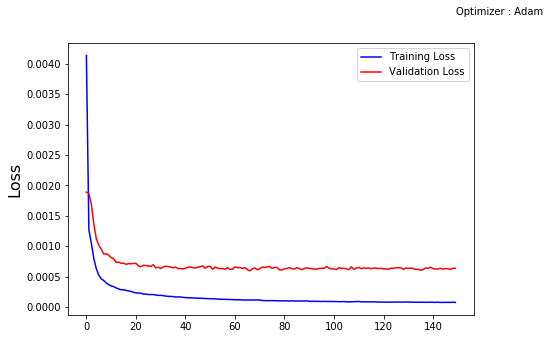

In [20]:
# loss 值的圖
# loss plot ( 繪製訓練 & 驗證的損失值)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot(繪製訓練 & 驗證的準確率值)
#plt.subplot(1, 2, 2)
#plt.ylabel('Accuracy', fontsize=16)
#plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
#plt.plot(hist.history['val_accurcay'], color='r', label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.show()

### 訓練歷史可視化

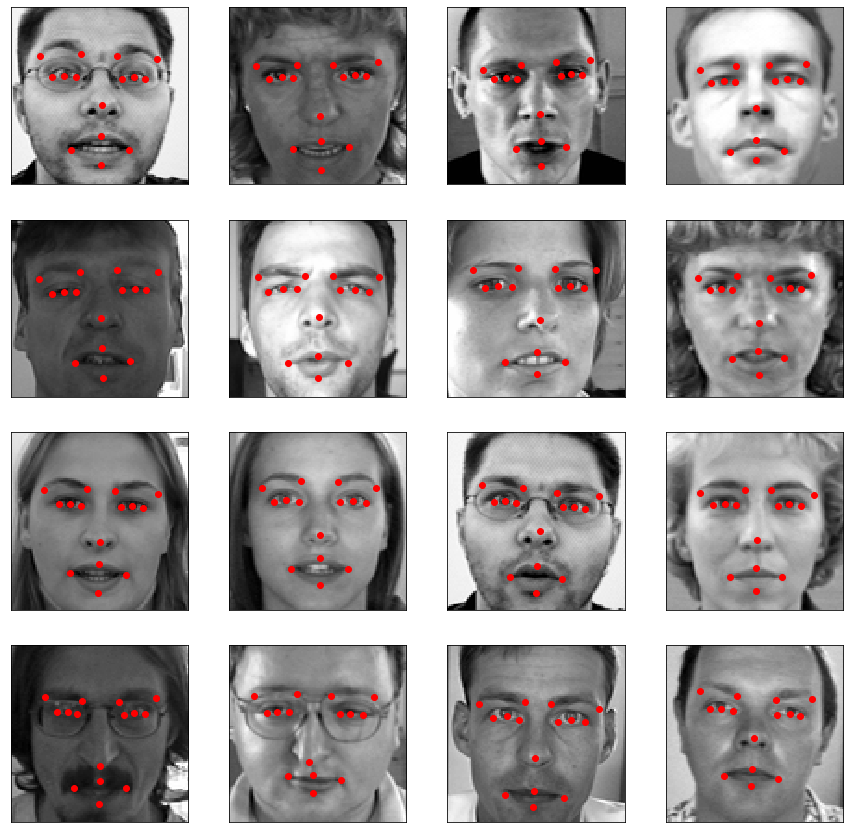

In [22]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [ ]:
from keras.utils.vis_utils import plot_model
import os
#plot_model 模型可視化
plot_model(model, 
           to_file='model_plot.png', 
           show_shapes=True,  # 指定是否顯示輸出數據的形狀
           show_layer_names=True) # 指定是否顯示層名稱